# Experiment 3.2: Evaluate using Inclusion/Exclusion curves

In [207]:
import matplotlib.pyplot as plt

import numpy as np

import pandas as pd

from sklearn import metrics

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from captum.attr import IntegratedGradients, Saliency, NoiseTunnel, InputXGradient, LRP, DeepLift
from captum.attr import visualization as viz
from captum.attr._utils.lrp_rules import EpsilonRule

#### Load the CIFAR-10 dataset 

In [208]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=400,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


#### Define the Convolutional neural network

In [209]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv_net = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 5, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )

        self.lin_net = nn.Sequential(
            nn.Linear(64 * 4 * 4, 180),
            nn.ReLU(),
            nn.Linear(180, 84),
            nn.ReLU(),
            nn.Linear(84, 10)
        )
        

    def forward(self, input):
        x = self.conv_net(input)
        x = x.view(-1, 64 * 4 * 4)
        x = self.lin_net(x)
        return x



net = Net()
net.conv_net.rule = EpsilonRule(0.1)
net.lin_net.rule = EpsilonRule(0.1)

#### Train the model or use a presaved model

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Sets if a new model should be trained or use the model from the last run
TRAIN_MODEL = False

PATH  = "model_image_recognition.pt"

if TRAIN_MODEL:

    for epoch in range(10):

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 2000 == 1999:    
                print('[%d, %5d] loss: %.3f' %
                    (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    torch.save(net.state_dict(), PATH)

else:
    net.load_state_dict(torch.load(PATH, weights_only=True))


print('Finished Training')

[1,  2000] loss: 2.293
[1,  4000] loss: 1.990
[1,  6000] loss: 1.739
[1,  8000] loss: 1.589
[1, 10000] loss: 1.467
[1, 12000] loss: 1.375
[2,  2000] loss: 1.288
[2,  4000] loss: 1.214
[2,  6000] loss: 1.173
[2,  8000] loss: 1.124
[2, 10000] loss: 1.075
[2, 12000] loss: 1.027
[3,  2000] loss: 0.964
[3,  4000] loss: 0.924
[3,  6000] loss: 0.932
[3,  8000] loss: 0.926
[3, 10000] loss: 0.917
[3, 12000] loss: 0.897
[4,  2000] loss: 0.782
[4,  4000] loss: 0.821
[4,  6000] loss: 0.790
[4,  8000] loss: 0.772
[4, 10000] loss: 0.788
[4, 12000] loss: 0.791
[5,  2000] loss: 0.653
[5,  4000] loss: 0.674
[5,  6000] loss: 0.682
[5,  8000] loss: 0.696
[5, 10000] loss: 0.687
[5, 12000] loss: 0.704
[6,  2000] loss: 0.568
[6,  4000] loss: 0.604
[6,  6000] loss: 0.605
[6,  8000] loss: 0.595
[6, 10000] loss: 0.587
[6, 12000] loss: 0.625
[7,  2000] loss: 0.454
[7,  4000] loss: 0.508
[7,  6000] loss: 0.526
[7,  8000] loss: 0.529
[7, 10000] loss: 0.546
[7, 12000] loss: 0.541
[8,  2000] loss: 0.402
[8,  4000] 

#### Define test images and labels to compute the attributions on

In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

torch.Size([3, 32, 32])


#### Print model accuracy on the samples to be attributed

In [213]:
outputs = net(images)
prediction = torch.max(outputs, 1).indices.detach().numpy()

acuracy = metrics.accuracy_score(labels, prediction)

print(f"Accuracy: {acuracy}")

Accuracy: 0.725


#### Method to compute the Exclusion$_{MoRF}$ and Exclusion$_{LeRF}$ curves

In [214]:
def generate_morf_lerf_curves(method, images, labels, set_to=0, **kwargs):
    mean_morf_curve = []

    attr = method.attribute(images, target=labels, **kwargs)

    if ('abs', True) in kwargs.items():

        attr = torch.square(attr)

    for ind in range(len(images)):

        morf_curve = []

        example_image = images[ind]

        example_label = labels[ind]

        attr_sum = np.sum((attr[ind].detach().numpy()), axis=0)


        example_image_copy = example_image.clone()

        if torch.max(net(example_image), 1).indices.detach().numpy() != example_label.item():

            continue

        for i in range(32*32):

            output = net(example_image_copy)
    
            classification_score = (F.softmax(output, dim=1).detach())[0, example_label]

            morf_curve.append(classification_score.item())

            max_index = np.unravel_index(np.nanargmax(attr_sum, axis=None), attr_sum.shape)

            attr_sum[max_index] = np.nan

            if set_to == "random":

                example_image_copy[:, max_index[0], max_index[1]] = torch.rand(3) * 2 -1

            else:    

                example_image_copy[:, max_index[0], max_index[1]] = set_to
        
        mean_morf_curve.append(morf_curve)

    mean_morf_curve = np.array(mean_morf_curve).mean(0)



    mean_lerf_curve = []

    attr = method.attribute(images, target=labels, **kwargs)

    if ('abs', True) in kwargs.items():

        attr = torch.square(attr)

    for ind in range(len(images)):

        lerf_curve = []

        example_image = images[ind]

        example_label = labels[ind]

        attr_sum = np.sum((attr[ind].detach().numpy()), axis=0)


        example_image_copy = example_image.clone()

        if torch.max(net(example_image), 1).indices.detach().numpy() != example_label.item():

            continue

        for i in range(32*32):

            output = net(example_image_copy)
    
            classification_score = (F.softmax(output, dim=1).detach())[0, example_label]

            lerf_curve.append(classification_score.item())

            min_index = np.unravel_index(np.nanargmin(attr_sum, axis=None), attr_sum.shape)

            attr_sum[min_index] = np.nan
            
            if set_to == "random":

                example_image_copy[:, min_index[0], min_index[1]] = torch.rand(3) * 2 -1

            else:    

                example_image_copy[:, min_index[0], min_index[1]] = set_to

        mean_lerf_curve.append(lerf_curve)

    mean_lerf_curve = np.array(mean_lerf_curve).mean(0)

    abpc = np.sum(np.subtract(np.array(mean_lerf_curve), np.array(mean_morf_curve)))/len(mean_morf_curve)
    
    return mean_morf_curve, mean_lerf_curve, abpc

#### Method to compute the curve for randomly chosing the pixels to replace

In [ ]:
def generate_rand_curve(images, labels, set_to=0):
    mean_rand_curve = []

    for ind in range(len(images)):

        rand_curve = []

        example_image = images[ind]

        example_label = labels[ind]

        attr = torch.rand(32, 32)

        example_image_copy = example_image.clone()

        if torch.max(net(example_image), 1).indices.detach().numpy() != example_label.item():

            continue

        for i in range(32*32):

            output = net(example_image_copy)
    
            classification_score = (F.softmax(output, dim=1).detach())[0, example_label]

            rand_curve.append(classification_score.item())

            max_index = np.unravel_index(np.nanargmax(attr, axis=None), attr.shape)

            attr[max_index] = np.nan
            
            if set_to == "random":

                example_image_copy[:, max_index[0], max_index[1]] = torch.rand(3) * 2 -1

            else:    

                example_image_copy[:, max_index[0], max_index[1]] = set_to
        
        mean_rand_curve.append(rand_curve)

    mean_rand_curve = np.array(mean_rand_curve).mean(0)

    
    return mean_rand_curve

#### Main method to compute all curves for the different methods and pixel-removal strategies

In [216]:
method_names = ["Gradient", "Saliency", "SmoothGrad", "LRP", "GradientxInput", "SmoothGradxInput",
                                          "Integrated Gradients", "DeepLIFT"]

data_rand = []
data = []

for baseline in [-1, 0, "random"]:
    sal = Saliency(net)
    ixg = InputXGradient(net)

    rand_curve = generate_rand_curve(images, labels, set_to=baseline)

    data_rand.append({'method': "Random", 'baseline': baseline, "curve": rand_curve})

    if baseline != "random":

        for (method, kwargs, name) in zip((Saliency(net), Saliency(net), NoiseTunnel(sal), LRP(net), InputXGradient(net),
                                        NoiseTunnel(ixg), IntegratedGradients(net), DeepLift(net)), 
                                        ({"abs": False}, {"abs": True}, {"abs": False,  "nt_samples": 50, "stdevs": 0.4},{}, {},
                                        {"nt_samples": 50, "stdevs": 0.4}, {"baselines": baseline}, {"baselines": baseline}),
                                        method_names):
        
            morf_curve, lerf_curve, abpc = generate_morf_lerf_curves(method, images, labels, set_to=baseline, **kwargs)

            data.append({'method': name, 'baseline': baseline, "morf_curve": morf_curve, "lerf_curve": lerf_curve, "abpc": abpc})

    else:

        for (method, kwargs, name) in zip((Saliency(net), Saliency(net), NoiseTunnel(sal), LRP(net), InputXGradient(net),
                                        NoiseTunnel(ixg), IntegratedGradients(net), DeepLift(net)), 
                                        ({"abs": False}, {"abs": True}, {"abs": False,  "nt_samples": 50, "stdevs": 0.4},{}, {},
                                        {"nt_samples": 50, "stdevs": 0.4}, {"baselines": 0}, {"baselines": 0}),
                                        method_names):
        
            morf_curve, lerf_curve, abpc = generate_morf_lerf_curves(method, images, labels, set_to=baseline, **kwargs)

            data.append({'method': name, 'baseline': baseline, "morf_curve": morf_curve, "lerf_curve": lerf_curve, "abpc": abpc})
        
        


/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/saliency.py:129: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/lrp.py:207: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(input_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/input_x_gradient.py:118: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/opt/anaconda3/li

#### Define Data Frame and method colors for the plots

In [217]:
df = pd.DataFrame(data)
df_rand = pd.DataFrame(data_rand)

method_colors = {
    "Gradient": 'darkgreen',
    "Saliency": 'red',
    "SmoothGrad": 'deepskyblue',
    "LRP": 'yellow',
    "GradientxInput": 'mediumseagreen',
    "SmoothGradxInput": 'navy',
    "Integrated Gradients": 'coral',
    "DeepLIFT": 'slateblue'
}

#### Plot curves for all methods in one diagram, Baseline 0

/var/folders/p6/q2_hk33x2k9g1znrbx4mvmrh0000gn/T/ipykernel_10655/722839694.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


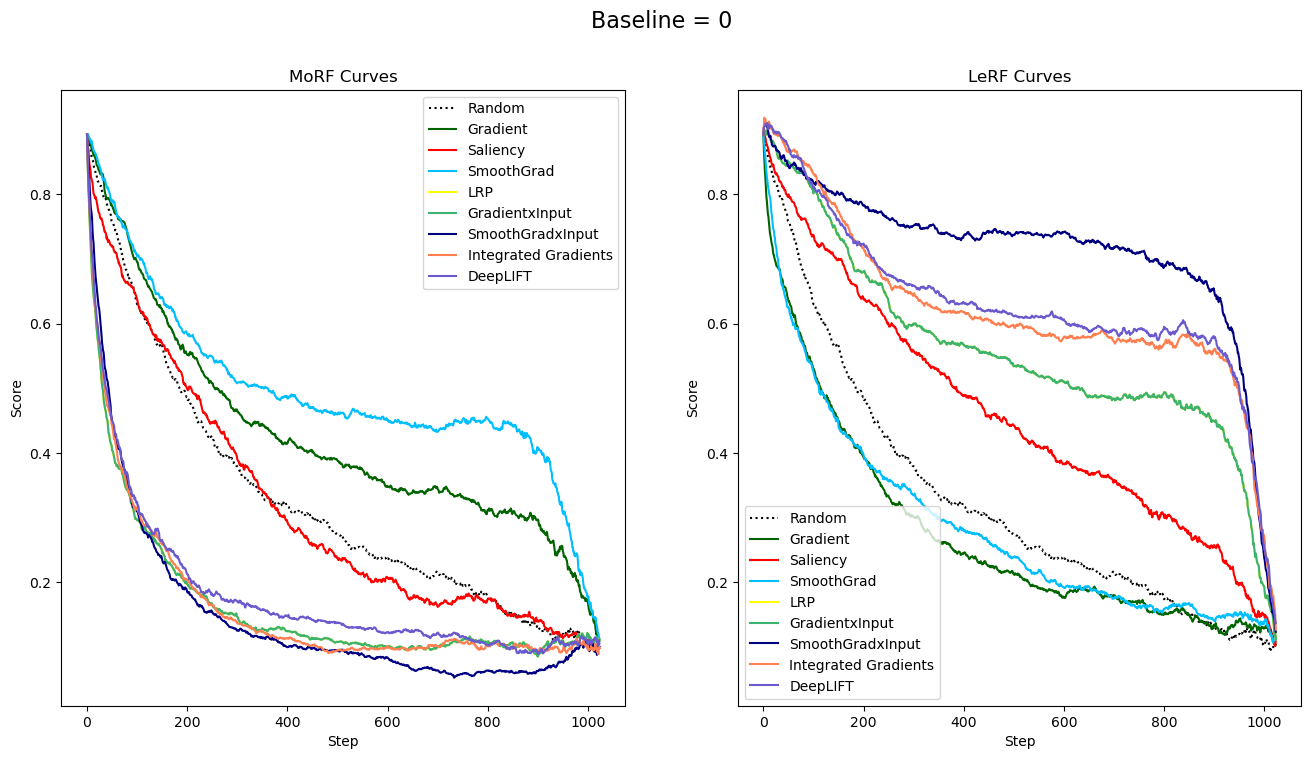

In [218]:

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))

fig.suptitle("Baseline = 0", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline==0:
        x = range(len(row["curve"]))
        ax1.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

        ax2.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

for _, row in df.iterrows():
    baseline = row["baseline"]
    if baseline==0:
        x = range(len(row["morf_curve"]))
        method = row["method"]
        baseline = row["baseline"]

        color = method_colors.get(method, "gray")

        ax1.plot(
            x,
            row["morf_curve"],
            label=f"{method}",
            color=color
        )

        x = range(len(row["lerf_curve"]))

        ax2.plot(
            x,
            row["lerf_curve"],
            label=f"{method}",
            color=color
        )

ax1.set_xlabel("Step")
ax1.set_ylabel("Score")
ax1.set_title("MoRF Curves")
ax1.legend()

ax2.set_xlabel("Step")
ax2.set_ylabel("Score")
ax2.set_title("LeRF Curves")
ax2.legend()
ax2.tick_params(labelleft=True, labelbottom=True)

fig.show()

#### Plot curves for all methods in one diagram, Baseline -1

/var/folders/p6/q2_hk33x2k9g1znrbx4mvmrh0000gn/T/ipykernel_10655/560738410.py:60: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


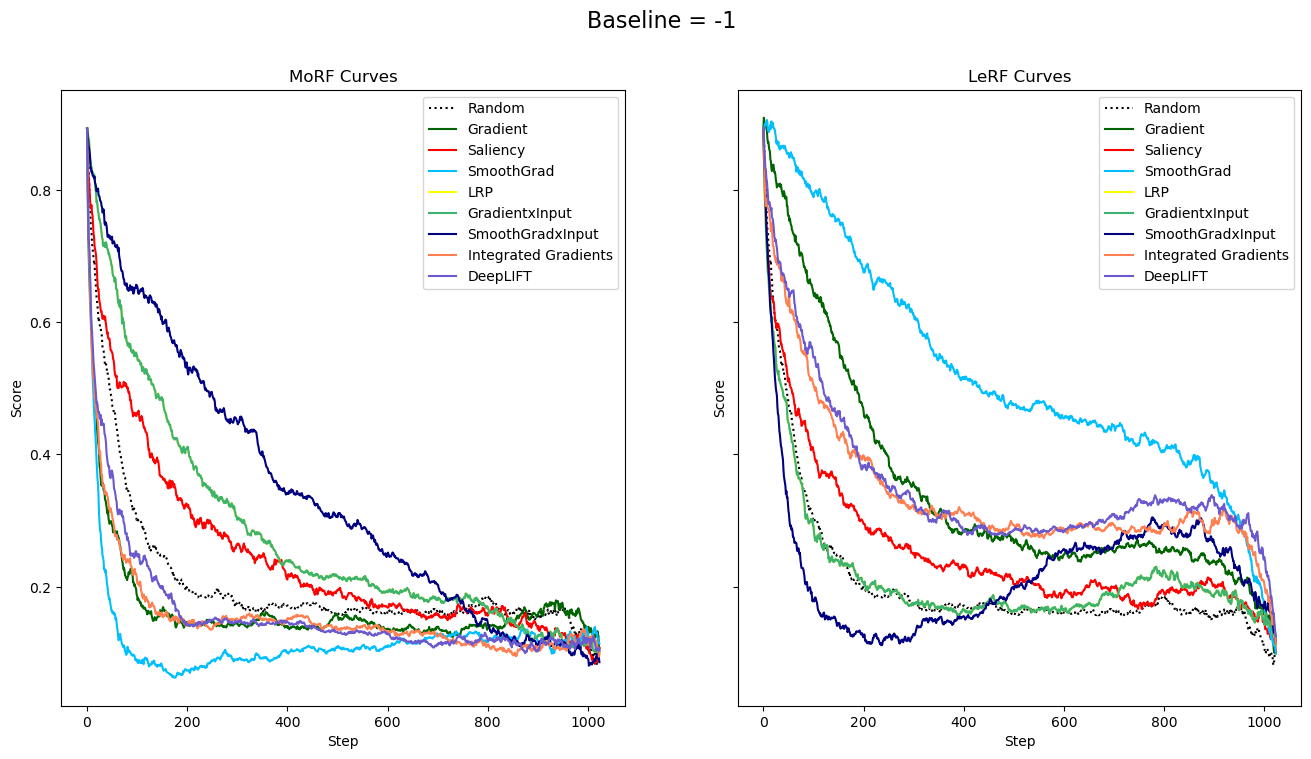

In [219]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))

fig.suptitle("Baseline = -1", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline==-1:
        x = range(len(row["curve"]))
        ax1.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

        ax2.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

for _, row in df.iterrows():
    baseline = row["baseline"]
    if baseline==-1:
        x = range(len(row["morf_curve"]))
        method = row["method"]
        baseline = row["baseline"]

        color = method_colors.get(method, "gray")

        ax1.plot(
            x,
            row["morf_curve"],
            label=f"{method}",
            color=color
        )

        x = range(len(row["lerf_curve"]))

        ax2.plot(
            x,
            row["lerf_curve"],
            label=f"{method}",
            color=color
        )

ax1.set_xlabel("Step")
ax1.set_ylabel("Score")
ax1.set_title("MoRF Curves")
ax1.legend()

ax2.set_xlabel("Step")
ax2.set_ylabel("Score")
ax2.set_title("LeRF Curves")
ax2.legend()

fig.show()

#### Plot curves for all methods in one diagram, Baseline random

/var/folders/p6/q2_hk33x2k9g1znrbx4mvmrh0000gn/T/ipykernel_10655/139680971.py:61: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


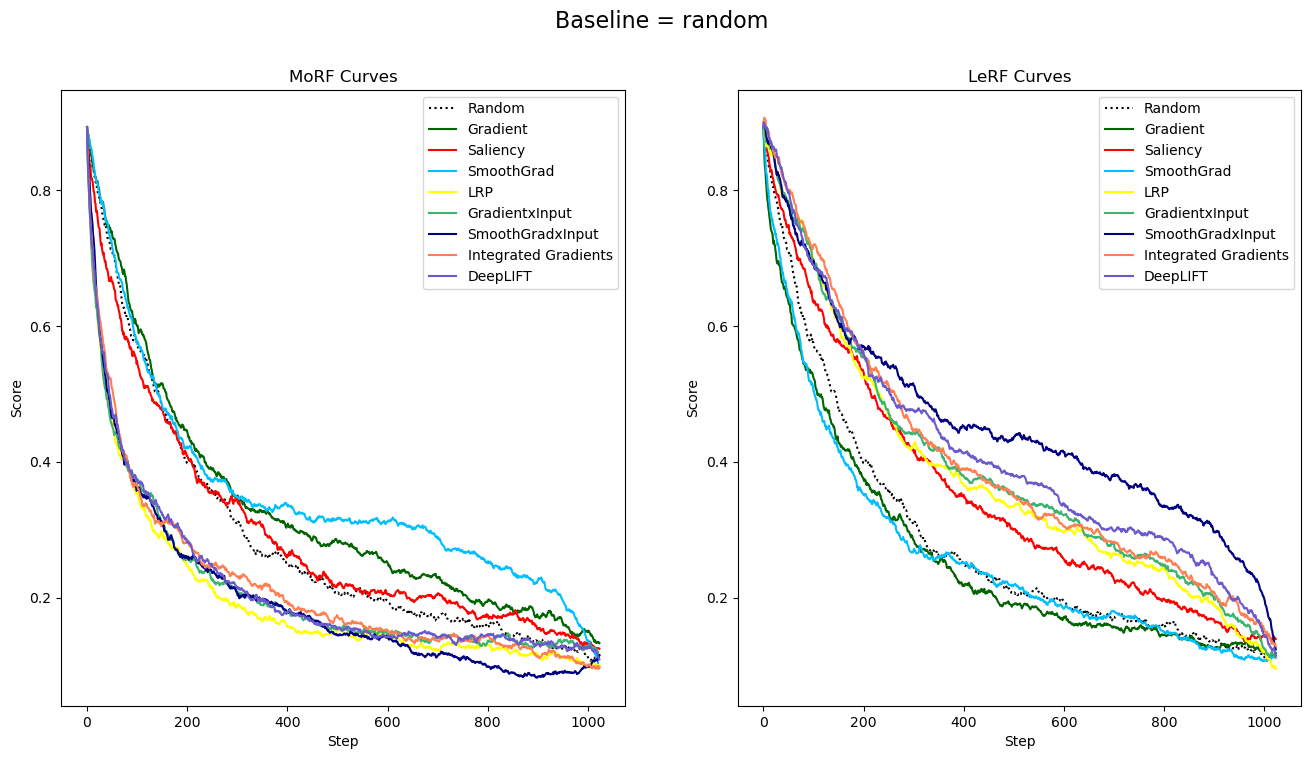

In [220]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16,8))

fig.suptitle("Baseline = random", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline=="random":
        x = range(len(row["curve"]))
        ax1.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

        ax2.plot(
            x,
            row["curve"],
            label="Random",
            color="black",
            linestyle=":"
        )

for _, row in df.iterrows():
    baseline = row["baseline"]
    if baseline=="random":
        x = range(len(row["morf_curve"]))
        method = row["method"]
        baseline = row["baseline"]

        color = method_colors.get(method, "gray")

        ax1.plot(
            x,
            row["morf_curve"],
            label=f"{method}",
            color=color
        )

        x = range(len(row["lerf_curve"]))

        ax2.plot(
            x,
            row["lerf_curve"],
            label=f"{method}",
            color=color
        )

ax1.set_xlabel("Step")
ax1.set_ylabel("Score")
ax1.set_title("MoRF Curves")
ax1.legend()

ax2.set_xlabel("Step")
ax2.set_ylabel("Score")
ax2.set_title("LeRF Curves")
ax2.legend()
ax2.tick_params(labelleft=True, labelbottom=True)

fig.show()

#### Plot curves for all methods seperately, Baseline -1

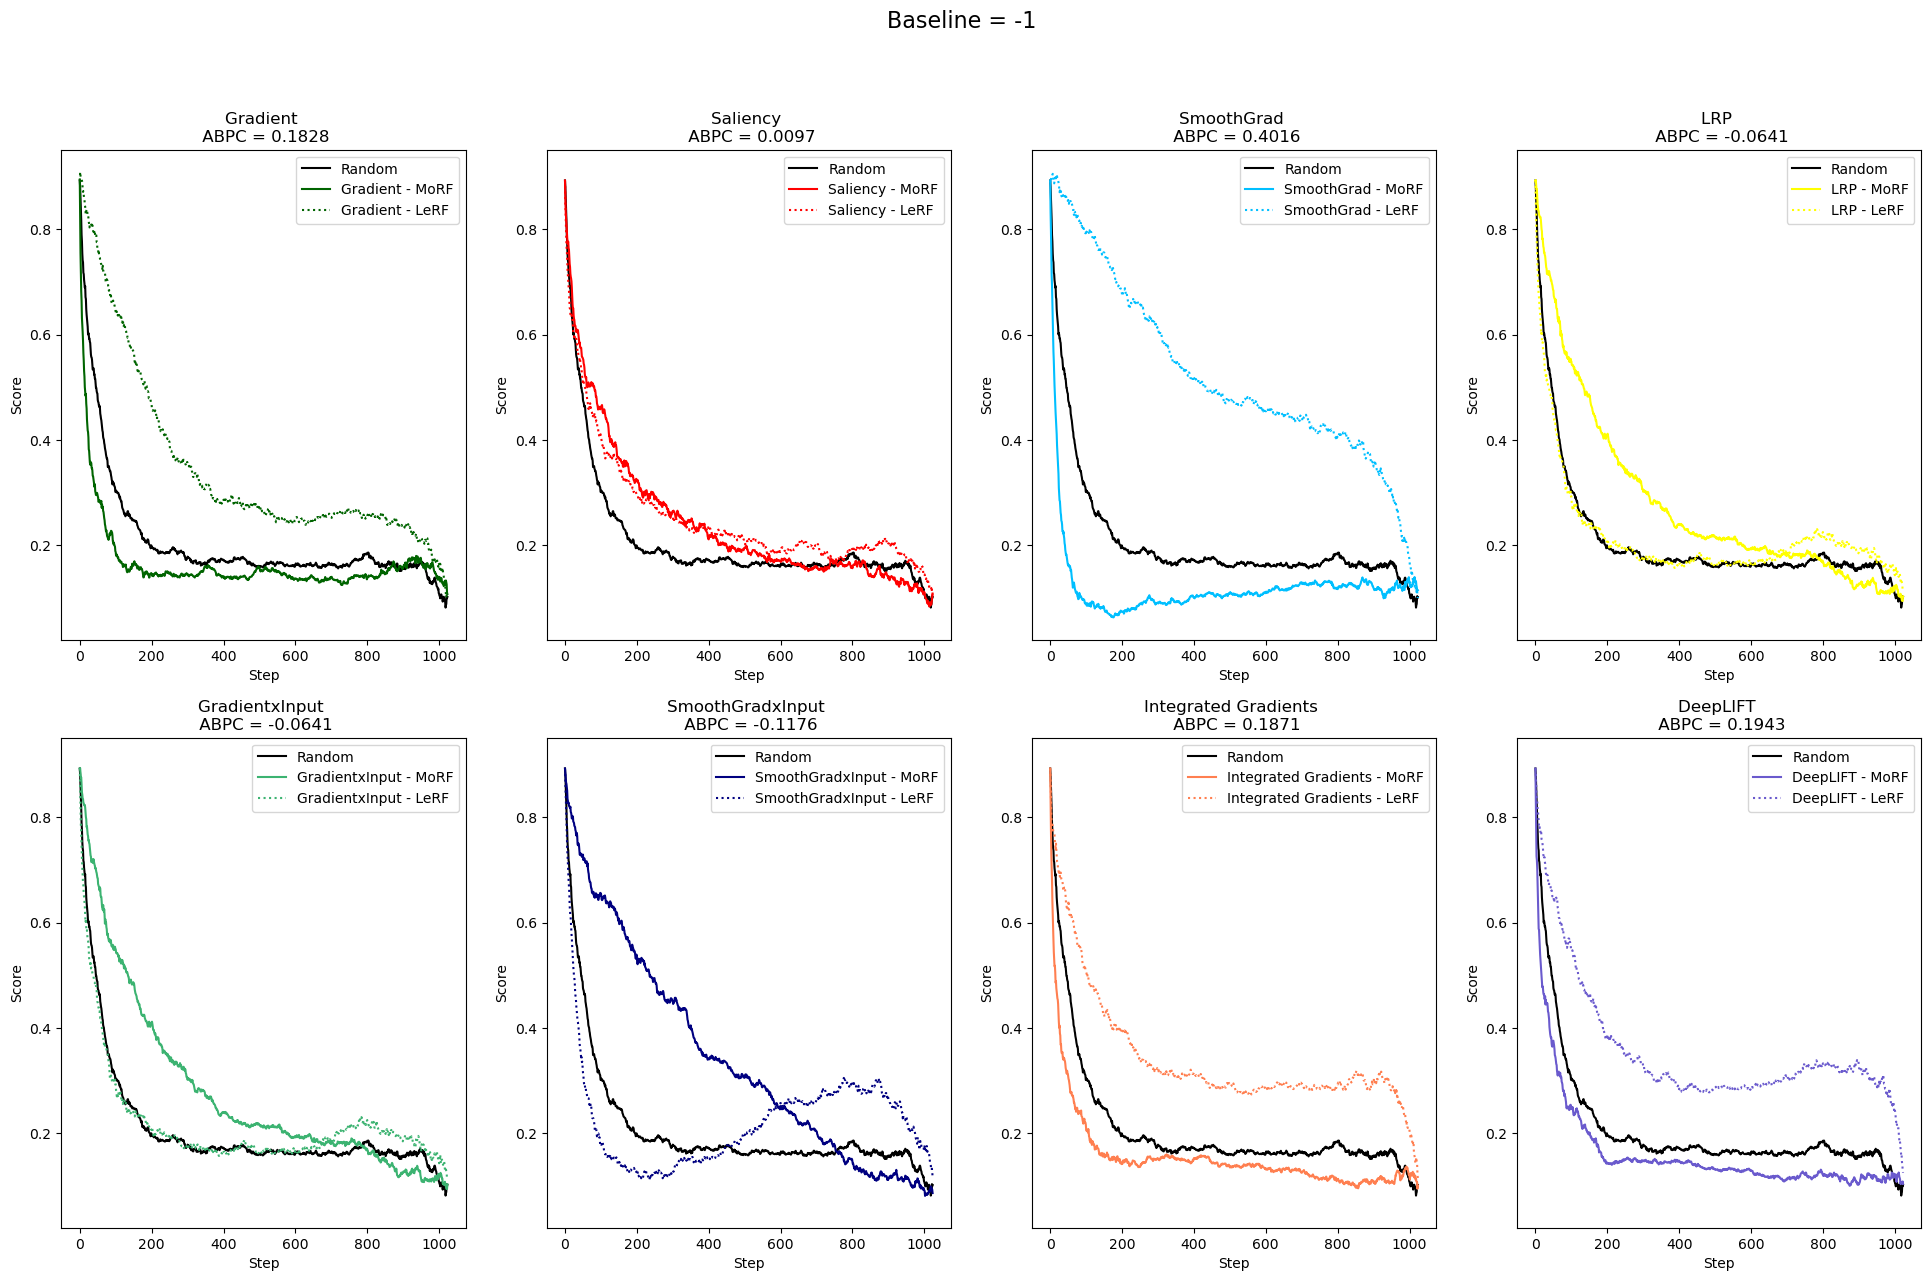

In [221]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(24,14))

fig.suptitle("Baseline = -1", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline == -1:
        x = range(len(row["curve"]))
        for ax in axs.flat:
            ax.plot(
                x,
                row["curve"],
                label="Random",
                color="black"
            )

for method_name, ax in zip(method_names, axs.flat):

    ax.tick_params(labelleft=True, labelbottom=True)
    
    for _, row in df.iterrows():
        baseline = row["baseline"]
        method = row["method"]
        color = method_colors.get(method, "gray")

        if baseline == -1 and method == method_name:

            ax.set_title(f"{method_name} \n ABPC = {row['abpc']:.4f}")

            x = range(len(row["morf_curve"]))

            ax.plot(
                x,
                row["morf_curve"],
                label=f"{method} - MoRF",
                color=color
            )

            x = range(len(row["lerf_curve"]))

            ax.plot(
                x,
                row["lerf_curve"],
                label=f"{method} - LeRF",
                color=color,
                linestyle=":"
            )

    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")
    

#### Plot curves for all methods seperately, Baseline 0

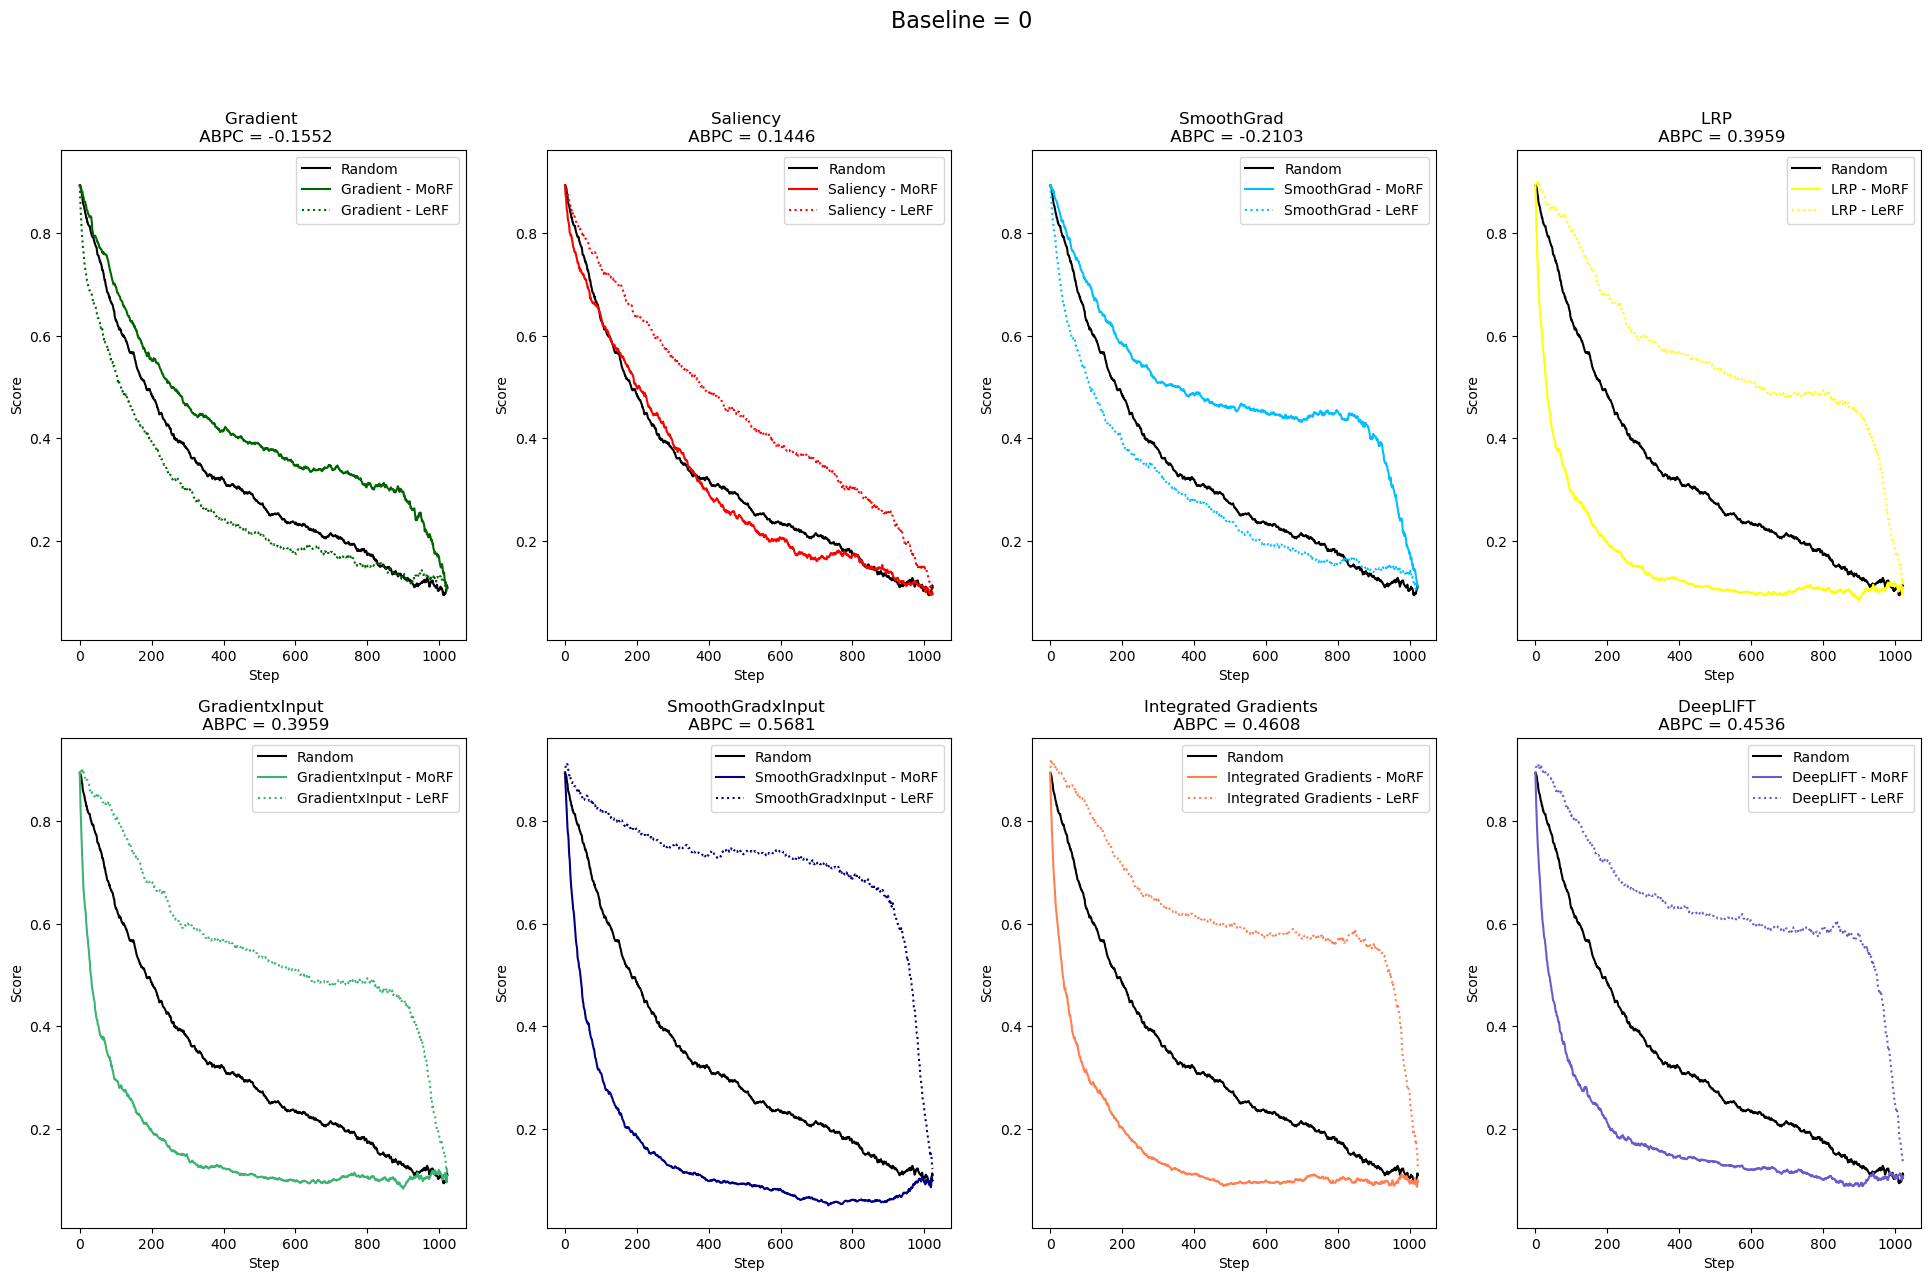

In [222]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(24,14))

fig.suptitle("Baseline = 0", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline == 0:
        x = range(len(row["curve"]))
        for ax in axs.flat:
            ax.plot(
                x,
                row["curve"],
                label="Random",
                color="black"
            )

for method_name, ax in zip(method_names, axs.flat):

    ax.tick_params(labelleft=True, labelbottom=True)
    
    for _, row in df.iterrows():
        baseline = row["baseline"]
        method = row["method"]
        color = method_colors.get(method, "gray")

        if baseline == 0 and method == method_name:

            ax.set_title(f"{method_name} \n ABPC = {row['abpc']:.4f}")

            x = range(len(row["morf_curve"]))

            ax.plot(
                x,
                row["morf_curve"],
                label=f"{method} - MoRF",
                color=color
            )

            x = range(len(row["lerf_curve"]))

            ax.plot(
                x,
                row["lerf_curve"],
                label=f"{method} - LeRF",
                color=color,
                linestyle=":"
            )

    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")

#### Plot curves for all methods seperately, Baseline random

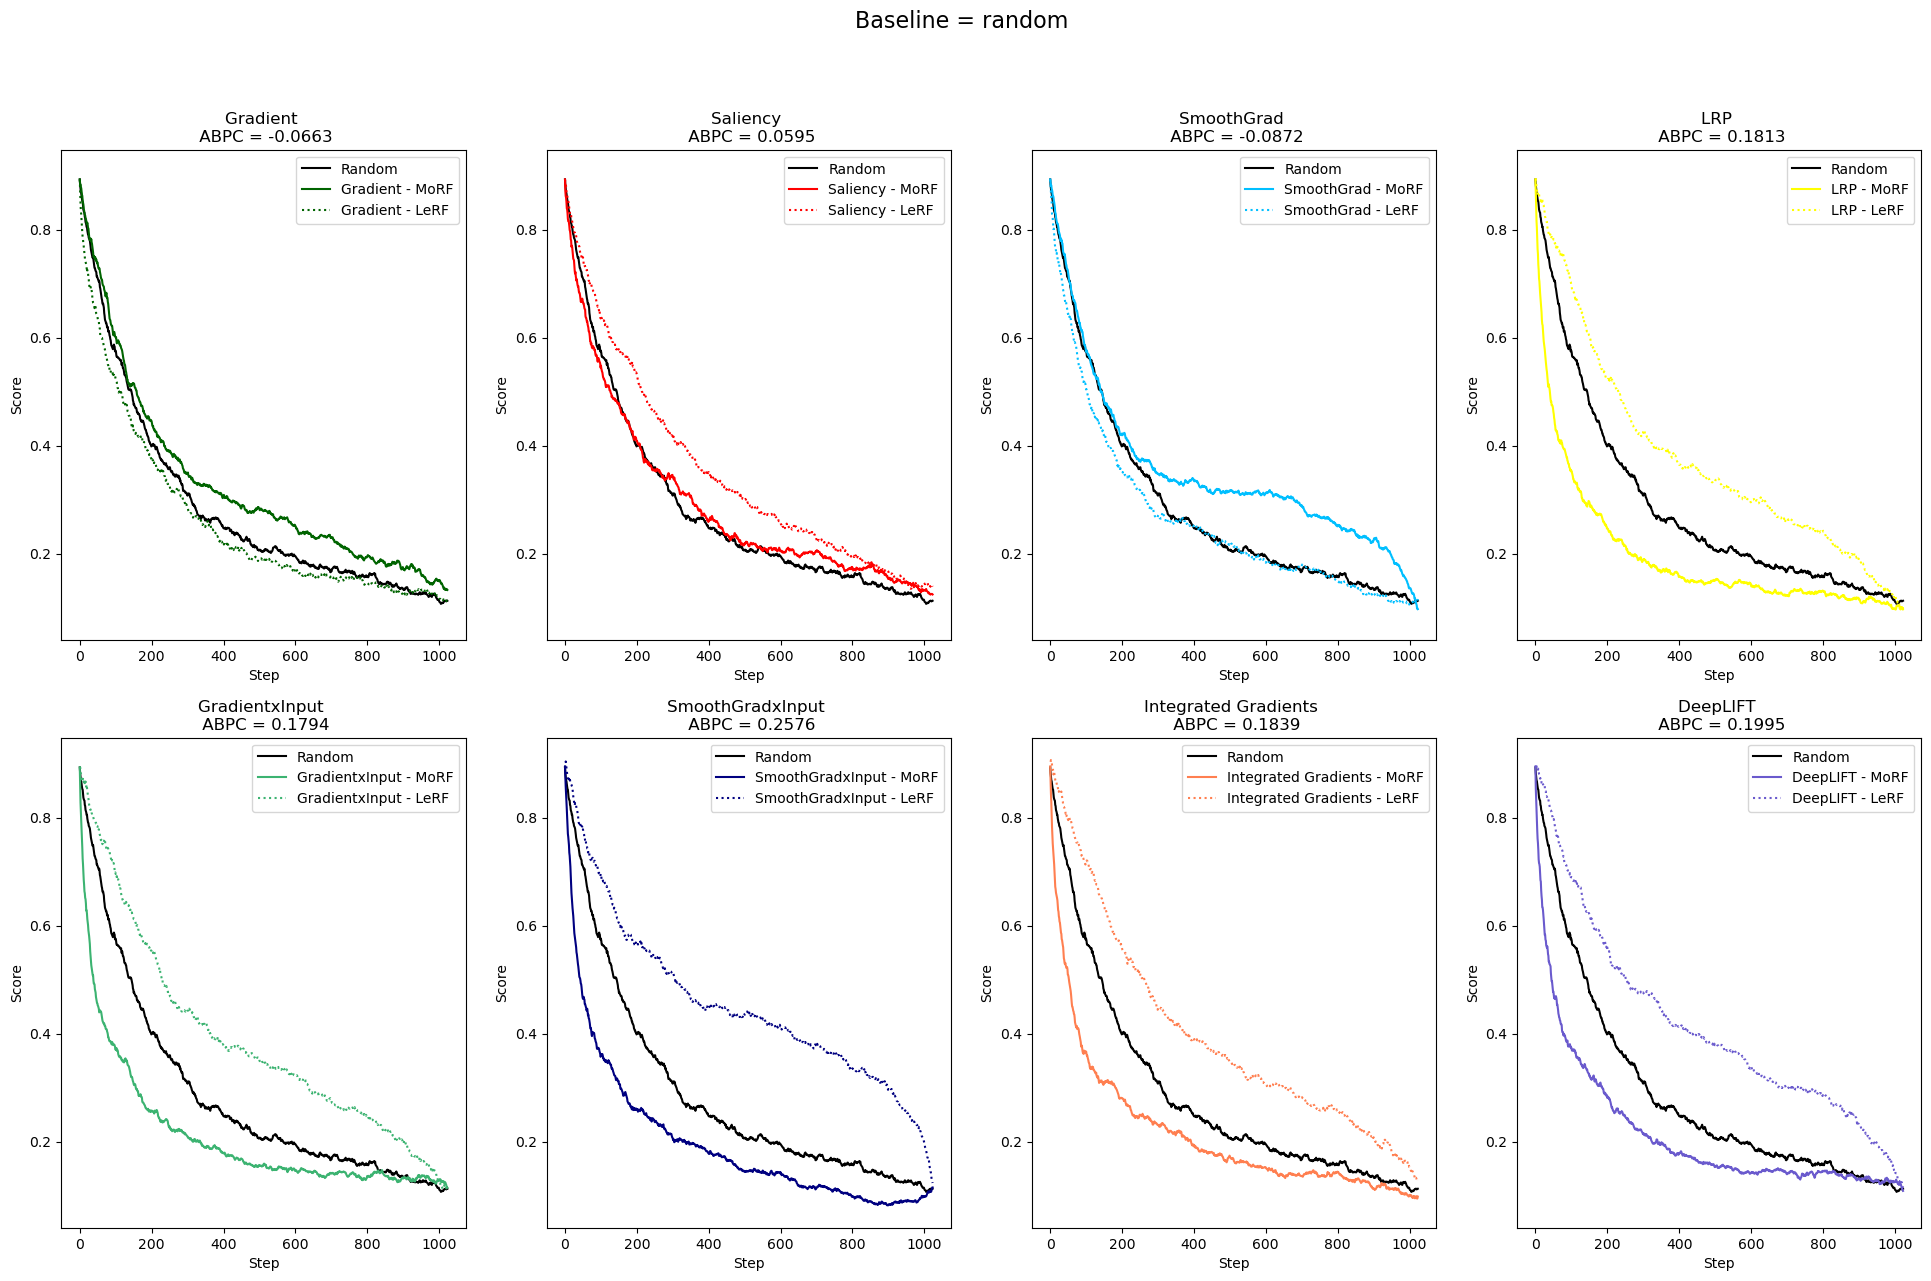

In [223]:
fig, axs = plt.subplots(2, 4, sharey=True, figsize=(24,14))

fig.suptitle("Baseline = random", fontsize=16)

for _, row in df_rand.iterrows():
    baseline = row["baseline"]
    if baseline == "random":
        x = range(len(row["curve"]))
        for ax in axs.flat:
            ax.plot(
                x,
                row["curve"],
                label="Random",
                color="black"
            )

for method_name, ax in zip(method_names, axs.flat):

    ax.tick_params(labelleft=True, labelbottom=True)
    
    for _, row in df.iterrows():
        baseline = row["baseline"]
        method = row["method"]
        color = method_colors.get(method, "gray")

        if baseline == "random" and method == method_name:

            ax.set_title(f"{method_name} \n ABPC = {row['abpc']:.4f}")

            x = range(len(row["morf_curve"]))

            ax.plot(
                x,
                row["morf_curve"],
                label=f"{method} - MoRF",
                color=color
            )

            x = range(len(row["lerf_curve"]))

            ax.plot(
                x,
                row["lerf_curve"],
                label=f"{method} - LeRF",
                color=color,
                linestyle=":"
            )

    ax.legend()
    ax.set_xlabel("Step")
    ax.set_ylabel("Score")